<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_efficientdet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart
[EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/pdf/1911.09070.pdf)

![](https://github.com/ai-fast-track/icevision/blob/fridge-tutorial/images/fridge-objects.png?raw=1)

## Introduction

This tutorial walk you through the different steps of training the fridge dataset. the IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

For more information about how the fridge dataset as well as its corresponding parser check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

## Installing IceVision and IceData

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# !pip install icevision[all] icedata -q
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade -q

In [ ]:
# !pip install icedata -q
!pip install git+git://github.com/airctic/icedata.git --upgrade -q

## Imports

In [1]:
from icevision.all import *

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [2]:
# Loading Data
data_dir = icedata.fridge.load_data()
parser = icedata.fridge.parser(data_dir)

  0%|          | 0/20380998 [00:00<?, ?B/s]

In [3]:
# Parsing
train_records, valid_records = parser.parse()

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


In [4]:
parser.class_map

<ClassMap: {'background': 0, 'milk_bottle': 1, 'carton': 2, 'can': 3, 'water_bottle': 4}>

## Train and Validation Dataset Transforms

In [7]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [8]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

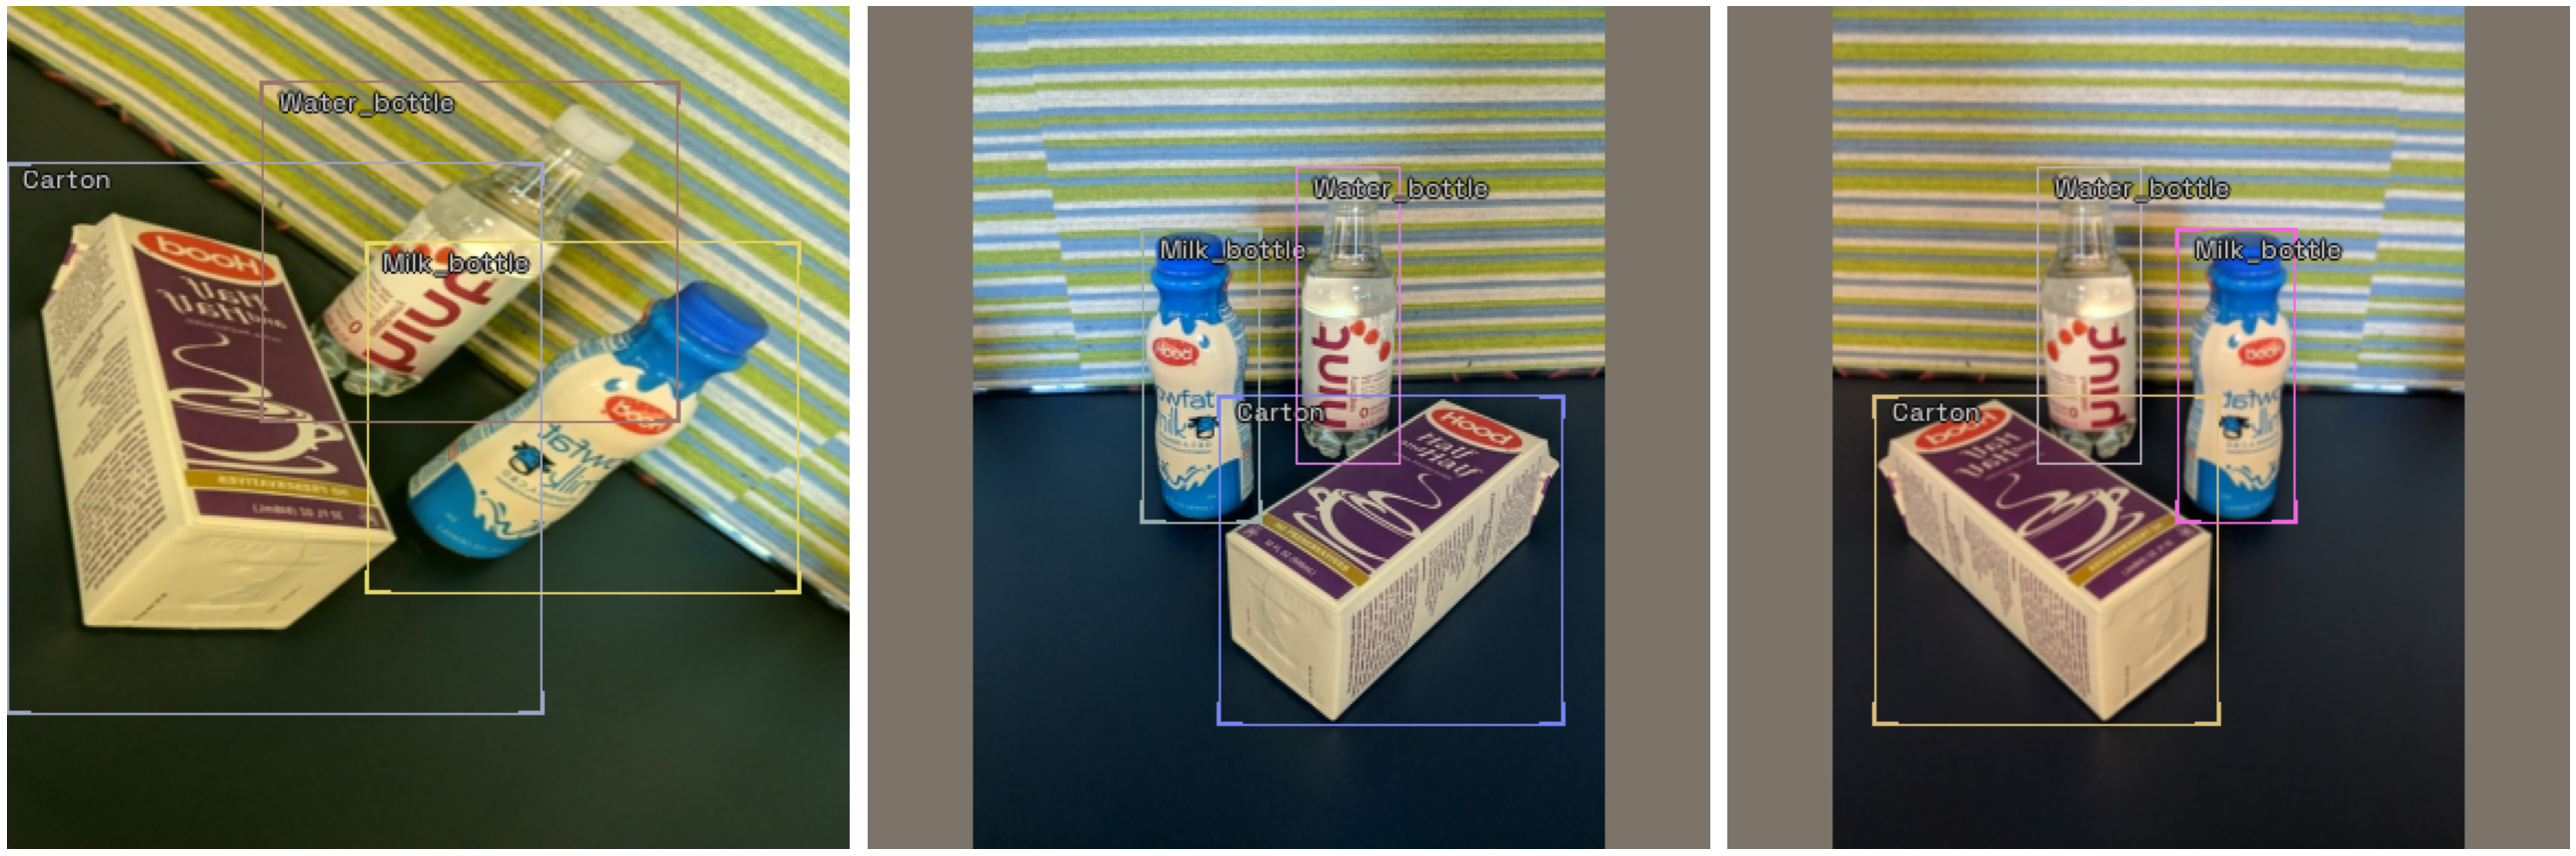

In [9]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=parser.class_map)

## DataLoader

In [10]:
model_type = models.ross.efficientdet

In [11]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

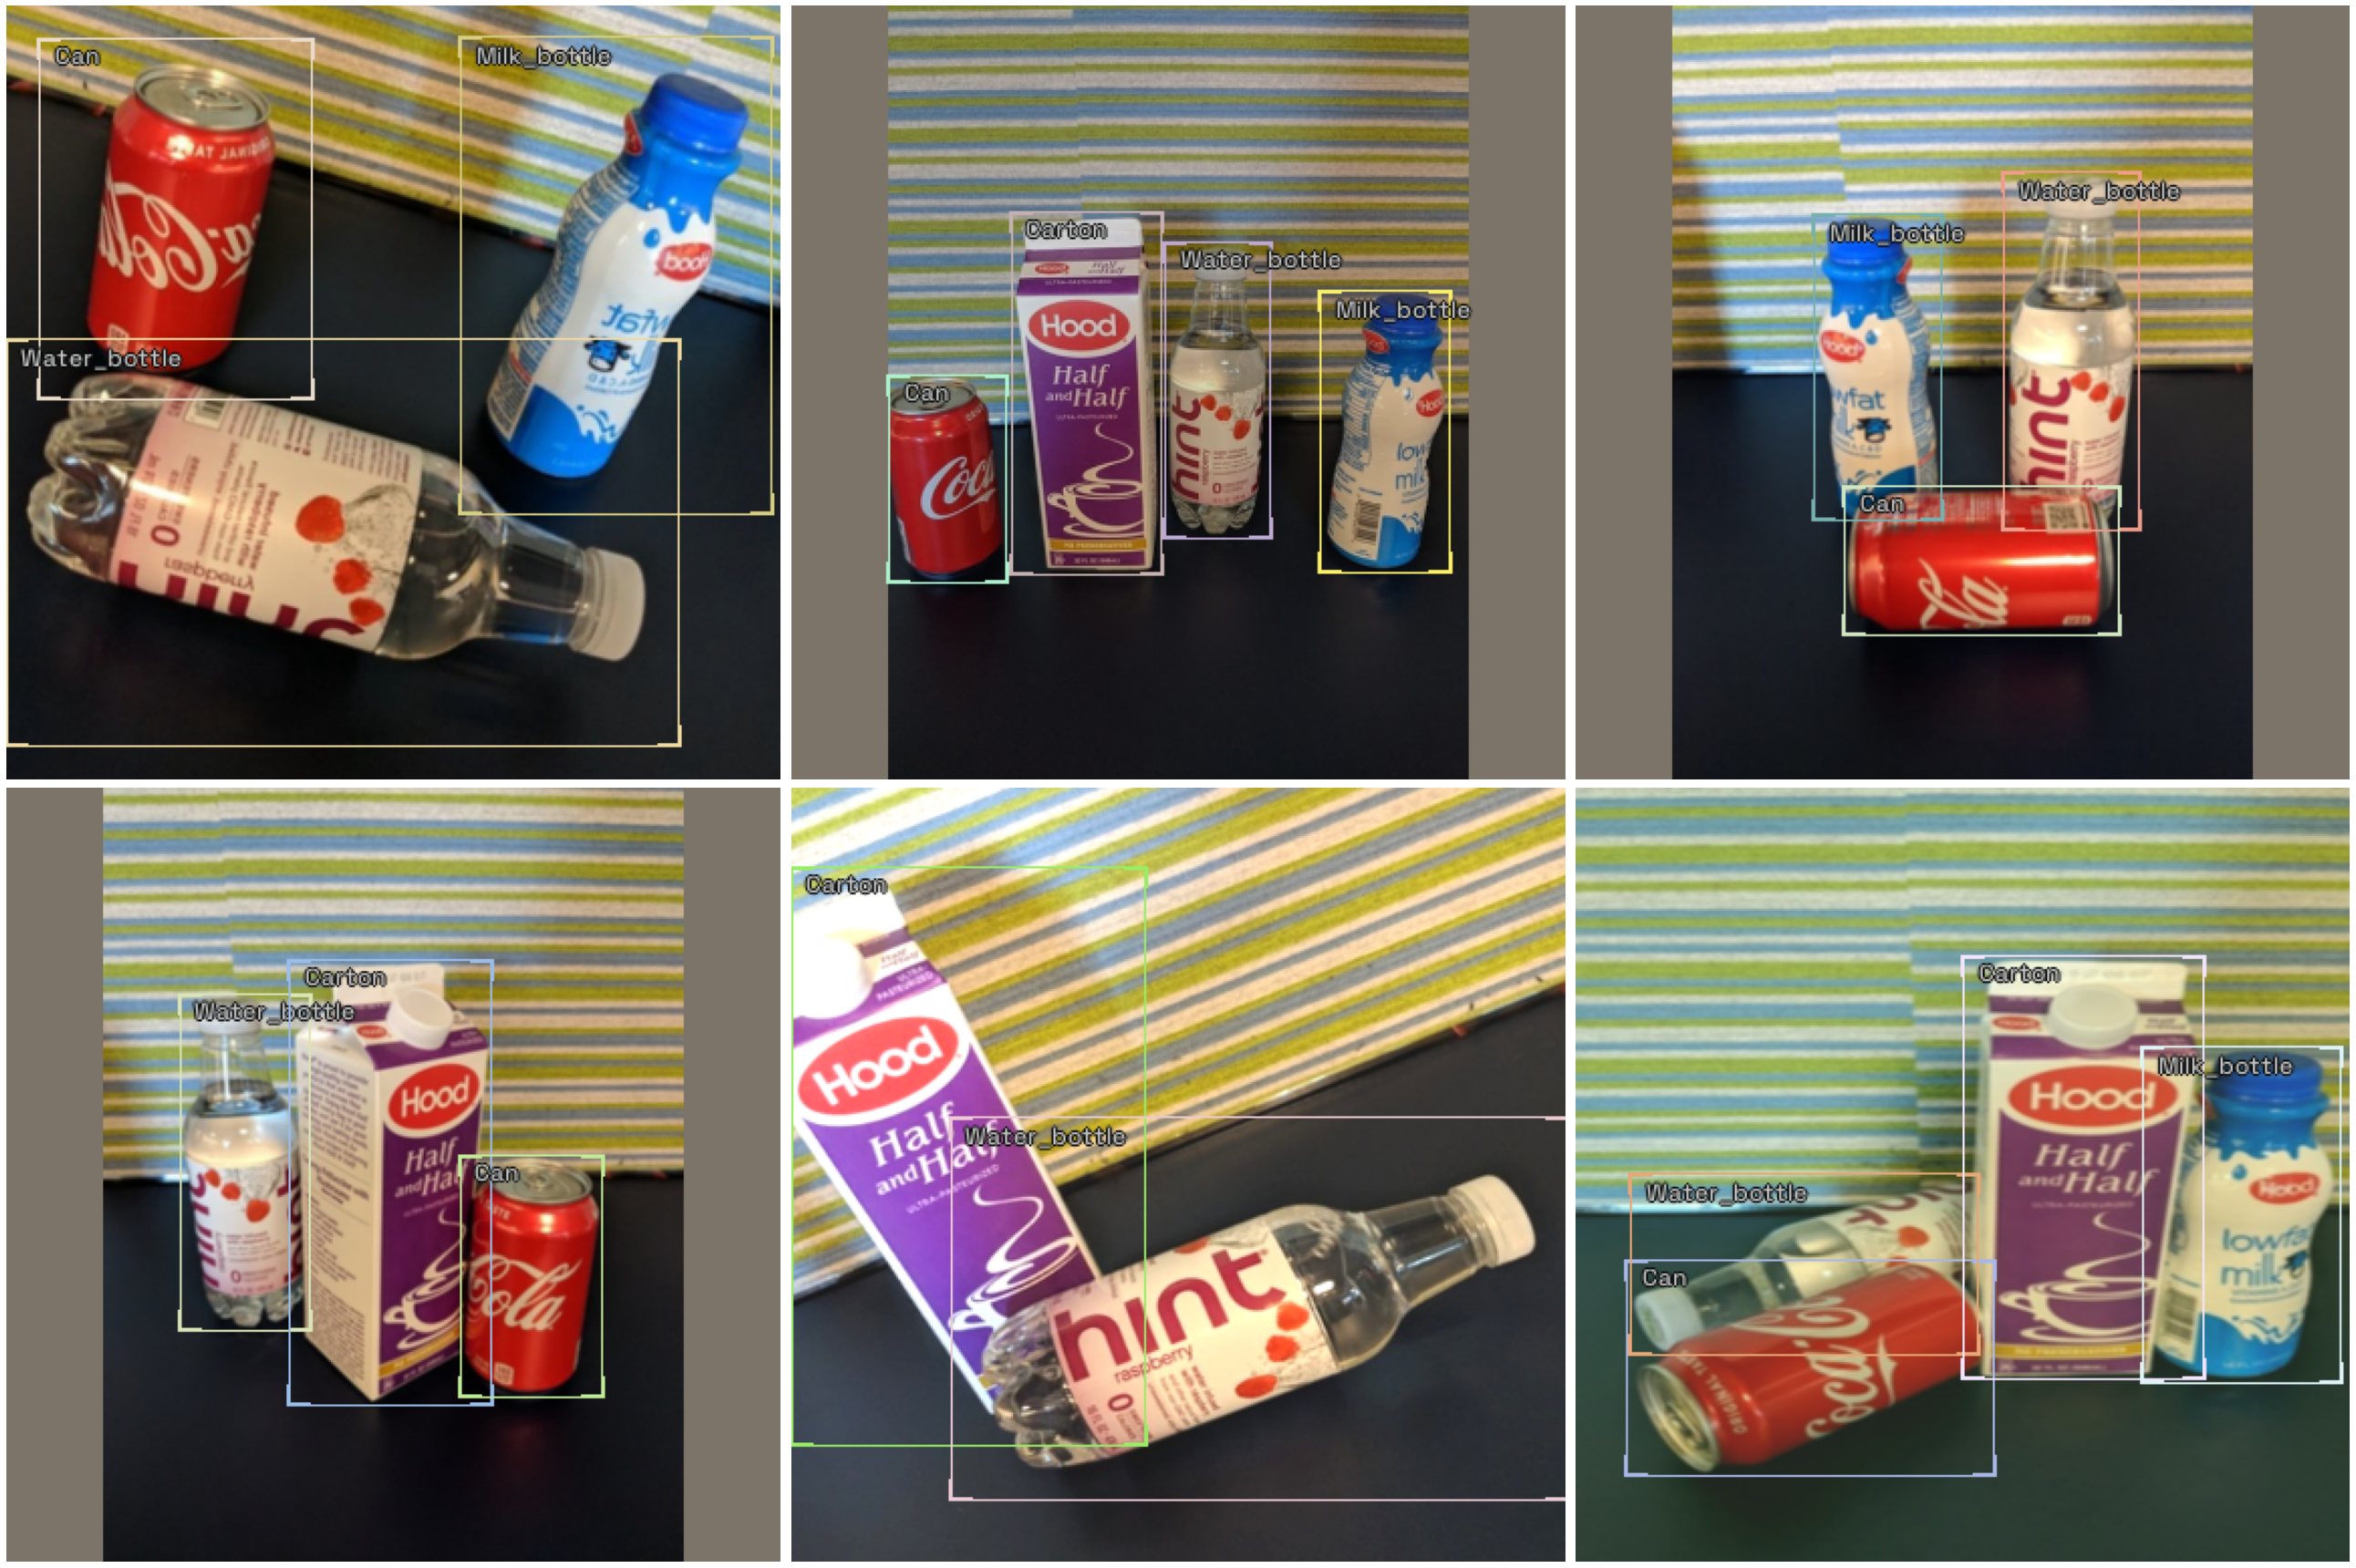

In [12]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3)

## Model

In [13]:
backbone = model_type.backbones.efficientdet_d0

In [15]:
model = efficientdet.model(backbone=backbone, num_classes=len(parser.class_map), img_size=384)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/efficientdet_d0-f3276ba8.pth" to /root/.cache/torch/hub/checkpoints/efficientdet_d0-f3276ba8.pth


## Metrics

In [16]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [17]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

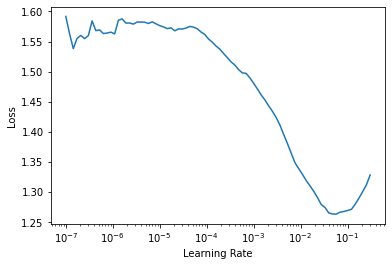

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(20, 1e-2, freeze_epochs=2)

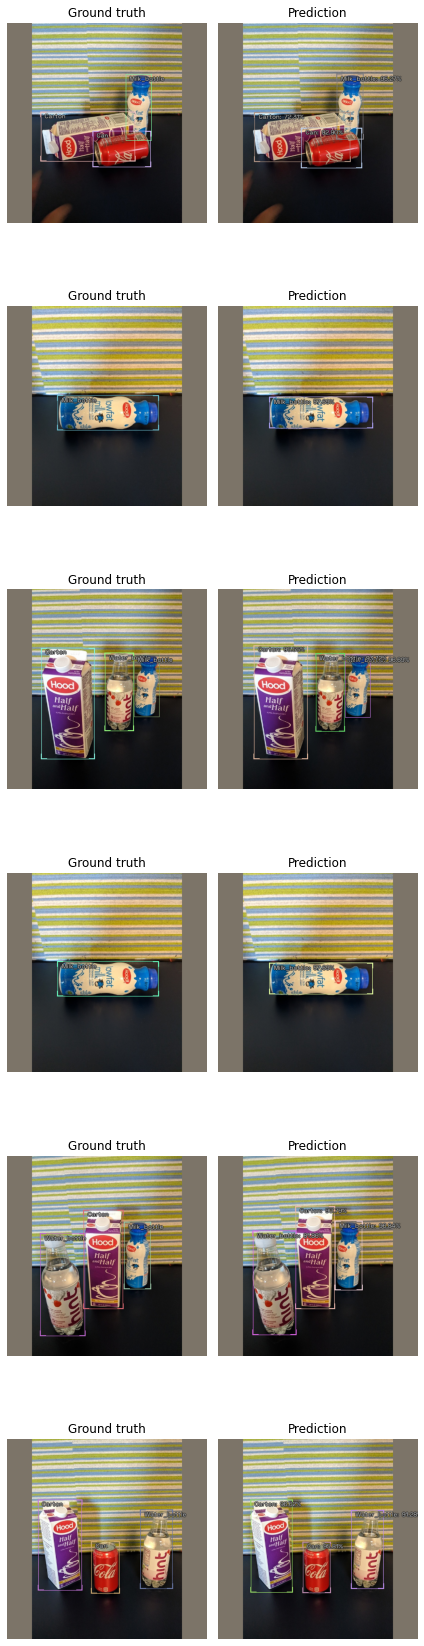

In [20]:
model_type.show_results(model, valid_ds)

### Training using Lightning

In [ ]:
class LightModel(efficientdet.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-2)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=50, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 


In [21]:
preds = model_type.predict(model, valid_ds)

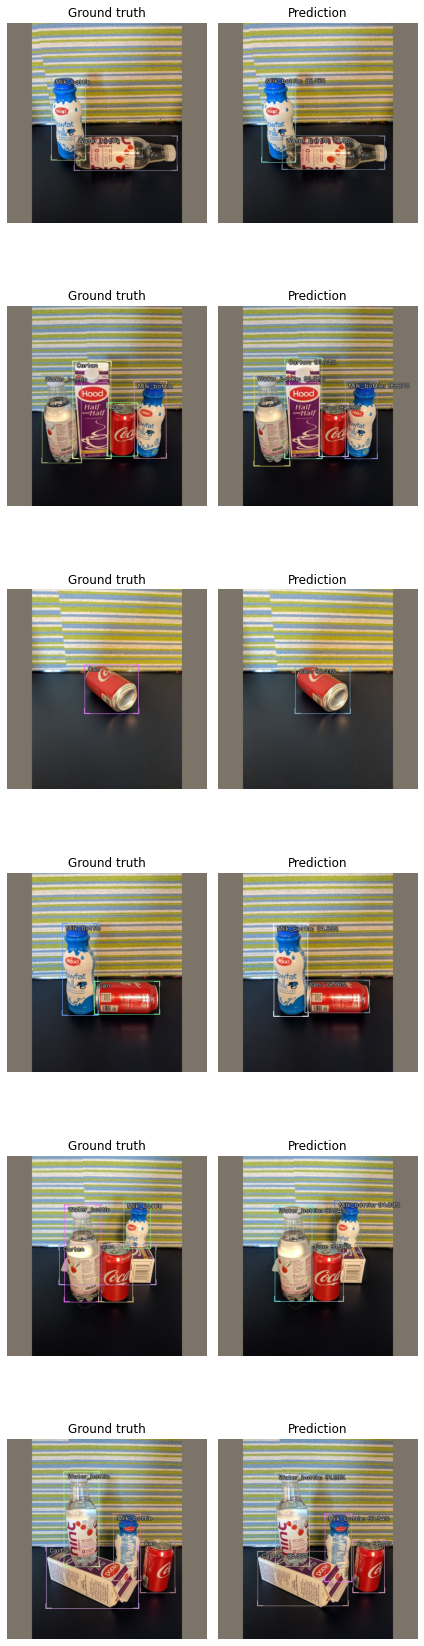

In [22]:
show_preds(
    preds=preds[:6],
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Saving Model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

In [ ]:
torch.save(model.state_dict(), root_dir/'icevision/models/fridge/fridge_tf_efficientdet_lite0.pth')

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).